# Convolutional Neural Network

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')

In [14]:
#drop timestamp
df = df.drop('timestamp', axis=1)

In [15]:
# Create mappings for userId and movieId to continuous indices
user_to_index = {user: i for i, user in enumerate(df['userId'].unique())}
movie_to_index = {movie: i for i, movie in enumerate(df['movieId'].unique())}

# Convert data to matrix using the mappings
num_users = len(user_to_index)
num_movies = len(movie_to_index)

ratings = torch.zeros((num_users, num_movies))
for row in df.itertuples():
    user_idx = user_to_index[row[1]]
    movie_idx = movie_to_index[row[2]]
    ratings[user_idx, movie_idx] = row[3]

# Model Architecture

In [16]:
# Define the CNN model
class RecommenderCNN(nn.Module):
    def __init__(self, num_users, num_movies):
        super(RecommenderCNN, self).__init__()
        self.user_embed = nn.Embedding(num_users, 64)
        self.movie_embed = nn.Embedding(num_movies, 64)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, users, movies):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        x = torch.cat([user_embeds, movie_embeds], dim=1)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()


In [17]:
# Define evaluation metrics
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return torch.sqrt(mse(y_true, y_pred))

In [18]:
model = RecommenderCNN(num_users, num_movies)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
from sklearn.model_selection import train_test_split
# Split data into training and test sets
train_indices, test_indices = train_test_split(range(len(df)), test_size=0.2, random_state=42)
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]

# Create training and test matrices
train_ratings = torch.zeros((num_users, num_movies))
test_ratings = torch.zeros((num_users, num_movies))
for row in train_df.itertuples():
    user_idx = user_to_index[row[1]]
    movie_idx = movie_to_index[row[2]]
    train_ratings[user_idx, movie_idx] = row[3]
for row in test_df.itertuples():
    user_idx = user_to_index[row[1]]
    movie_idx = movie_to_index[row[2]]
    test_ratings[user_idx, movie_idx] = row[3]

# Training and evaluation

In [23]:
# Training and evaluation
train_users, train_movies = torch.where(train_ratings > 0)
train_users = train_users.long()
train_movies = train_movies.long()

train_losses = []
test_losses = []
train_maes = []
test_maes = []
train_mses = []
test_mses = []

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_users, train_movies)
    loss = criterion(outputs, train_ratings[train_users, train_movies])
    loss.backward()
    optimizer.step()

    # Compute metrics for training data
    train_rmse_val = rmse(outputs, train_ratings[train_users, train_movies])
    train_mae_val = mae(outputs, train_ratings[train_users, train_movies])
    train_mse_val = mse(outputs, train_ratings[train_users, train_movies])
    train_losses.append(train_rmse_val.item())
    train_maes.append(train_mae_val.item())
    train_mses.append(train_mse_val.item())

    # Predictions on the test set
    test_users, test_movies = torch.where(test_ratings > 0)
    test_users = test_users.long()
    test_movies = test_movies.long()
    test_outputs = model(test_users, test_movies)
    test_loss = criterion(test_outputs, test_ratings[test_users, test_movies])

    # Compute metrics for test data
    test_rmse_val = rmse(test_outputs, test_ratings[test_users, test_movies])
    test_mae_val = mae(test_outputs, test_ratings[test_users, test_movies])
    test_mse_val = mse(test_outputs, test_ratings[test_users, test_movies])
    test_losses.append(test_rmse_val.item())
    test_maes.append(test_mae_val.item())
    test_mses.append(test_mse_val.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Training RMSE: {train_rmse_val.item()}, Test RMSE: {test_rmse_val.item()}")
    print(f"Epoch {epoch+1}/{num_epochs}, Training MAE: {train_mae_val.item()}, Test MAE: {test_mae_val.item()}")
    print(f"Epoch {epoch+1}/{num_epochs}, Training MSE: {train_mse_val.item()}, Test MSE: {test_mse_val.item()}")

Epoch 1/100, Training RMSE: 1.2725285291671753, Test RMSE: 1.2944198846817017
Epoch 1/100, Training MAE: 1.025118112564087, Test MAE: 1.0439331531524658
Epoch 1/100, Training MSE: 1.6193289756774902, Test MSE: 1.6755229234695435
Epoch 2/100, Training RMSE: 1.2695577144622803, Test RMSE: 1.2914435863494873
Epoch 2/100, Training MAE: 1.0217701196670532, Test MAE: 1.0419868230819702
Epoch 2/100, Training MSE: 1.6117767095565796, Test MSE: 1.6678264141082764
Epoch 3/100, Training RMSE: 1.2608075141906738, Test RMSE: 1.2828354835510254
Epoch 3/100, Training MAE: 1.0153133869171143, Test MAE: 1.034749150276184
Epoch 3/100, Training MSE: 1.5896357297897339, Test MSE: 1.6456669569015503
Epoch 4/100, Training RMSE: 1.253487467765808, Test RMSE: 1.2775477170944214
Epoch 4/100, Training MAE: 1.0087034702301025, Test MAE: 1.0296903848648071
Epoch 4/100, Training MSE: 1.5712307691574097, Test MSE: 1.632128119468689
Epoch 5/100, Training RMSE: 1.2537790536880493, Test RMSE: 1.2753746509552002
Epoch 

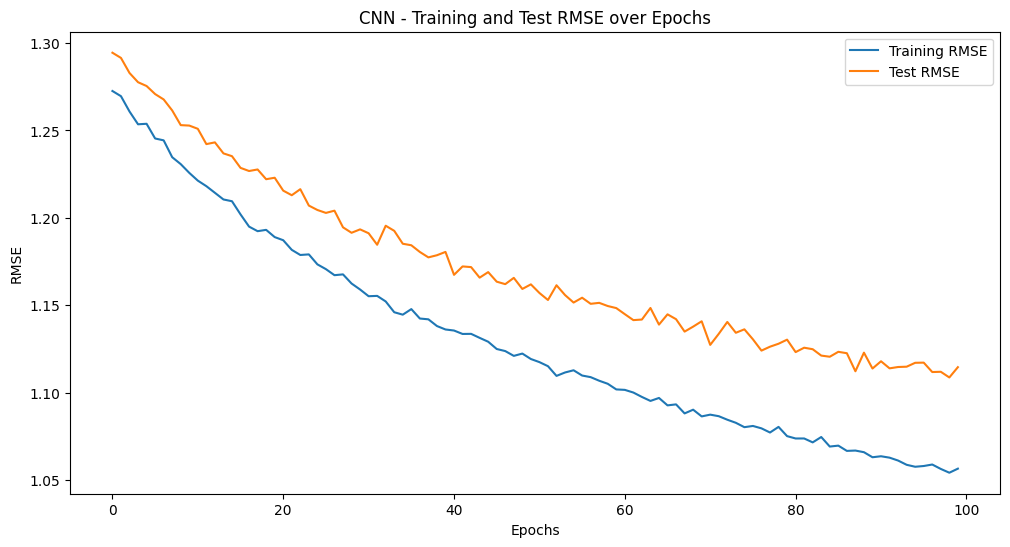

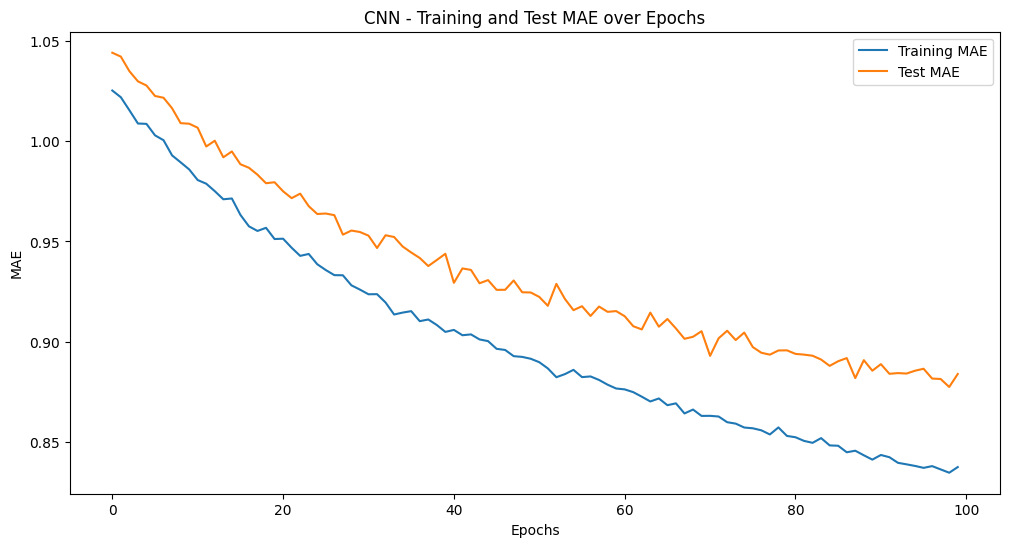

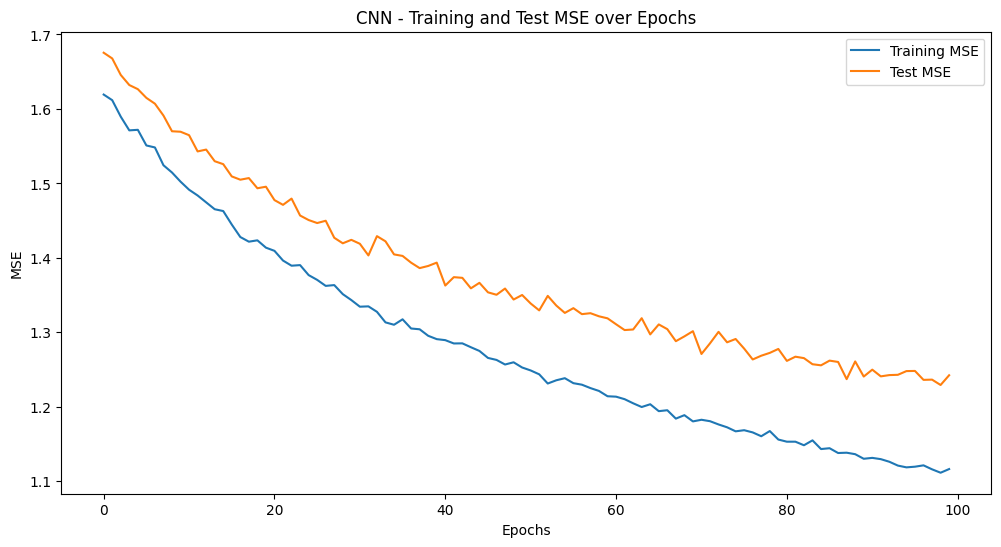

In [27]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
output_folder = "../../metrics/overleaf"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define model name
model_name = "CNN"

# Visualization

# RMSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training RMSE')
plt.plot(test_losses, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'{model_name} - Training and Test RMSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_rmse_plot.png'))  # Save the figure
plt.show()

# MAE plot
plt.figure(figsize=(12, 6))
plt.plot(train_maes, label='Training MAE')
plt.plot(test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title(f'{model_name} - Training and Test MAE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mae_plot.png'))  # Save the figure
plt.show()

# MSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_mses, label='Training MSE')
plt.plot(test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title(f'{model_name} - Training and Test MSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mse_plot.png'))  # Save the figure
plt.show()
